In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm


In [35]:
CSV_PATH = "traffic.csv"   # <-- same name you uploaded
df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
df.head()


Shape: (48120, 4)


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [36]:
first_col = df.columns[0]

try:
    df[first_col] = pd.to_datetime(df[first_col])
    print("Timestamp column detected:", first_col)
except:
    print("No timestamp found, creating dummy time index.")
    df.insert(0, "_timestamp", pd.date_range(start="2000-01-01", periods=len(df), freq="H"))
    first_col = "_timestamp"

df = df.sort_values(first_col).reset_index(drop=True)

sensor_cols = df.select_dtypes(include=[np.number]).columns.tolist()
sensor_cols[:10]


Timestamp column detected: DateTime


['Junction', 'Vehicles', 'ID']

In [37]:
data = df[sensor_cols].astype(float)
data = data.fillna(method='ffill').fillna(method='bfill').fillna(0.0)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.values)

n_sensors = data_scaled.shape[1]
print("Sensors:", n_sensors)


Sensors: 3


/var/folders/b7/f8ld_xjn70xfkg58__14kx9w0000gn/T/ipykernel_18456/1006624945.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill').fillna(0.0)


In [38]:
SEQ_LEN = 24     # past 24 time steps
PRED_LEN = 6     # predict next 6 steps

def make_sequences(X, seq_len, pred_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len - pred_len + 1):
        Xs.append(X[i:i+seq_len])
        ys.append(X[i+seq_len:i+seq_len+pred_len])
    return np.array(Xs), np.array(ys)

X, Y = make_sequences(data_scaled, SEQ_LEN, PRED_LEN)

print("X shape:", X.shape)
print("Y shape:", Y.shape)


X shape: (48091, 24, 3)
Y shape: (48091, 6, 3)


In [39]:
n = len(X)
train_i = int(n * 0.7)
val_i = int(n * 0.85)

X_train, Y_train = X[:train_i], Y[:train_i]
X_val, Y_val = X[train_i:val_i], Y[train_i:val_i]
X_test, Y_test = X[val_i:], Y[val_i:]

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (33663, 24, 3)
Val: (7214, 24, 3)
Test: (7214, 24, 3)


In [40]:
n = len(X)
train_i = int(n * 0.7)
val_i = int(n * 0.85)

X_train, Y_train = X[:train_i], Y[:train_i]
X_val, Y_val = X[train_i:val_i], Y[train_i:val_i]
X_test, Y_test = X[val_i:], Y[val_i:]

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (33663, 24, 3)
Val: (7214, 24, 3)
Test: (7214, 24, 3)


In [41]:
class LSTMForecast(nn.Module):
    def __init__(self, n_features, hidden_dim=64, num_layers=2, pred_len=6):
        super().__init__()
        self.lstm = nn.LSTM(n_features, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, n_features * pred_len)
        self.pred_len = pred_len
        self.n_features = n_features

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.view(-1, self.pred_len, self.n_features)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMForecast(n_sensors).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [42]:
n = len(X)
train_i = int(n * 0.7)
val_i = int(n * 0.85)

X_train, Y_train = X[:train_i], Y[:train_i]
X_val, Y_val = X[train_i:val_i], Y[train_i:val_i]
X_test, Y_test = X[val_i:], Y[val_i:]

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (33663, 24, 3)
Val: (7214, 24, 3)
Test: (7214, 24, 3)


In [43]:
from torch.utils.data import Dataset, DataLoader

class TrafficDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_loader = DataLoader(TrafficDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TrafficDataset(X_val, Y_val), batch_size=64)
test_loader = DataLoader(TrafficDataset(X_test, Y_test), batch_size=64)

print("Loaders ready.")


Loaders ready.


In [44]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMForecast(n_sensors).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

print("Model Ready on:", DEVICE)


Model Ready on: cpu


In [45]:
best_val = 1e9

for epoch in range(15):  # increase if you want
    model.train()
    train_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            val_loss += criterion(pred, yb).item()

    print(f"Epoch {epoch+1} | Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f}")

    if val_loss < best_val:
        torch.save(model.state_dict(), "best_lstm.pth")
        best_val = val_loss


Epoch 1 | Train Loss=18.1457 | Val Loss=6.2140
Epoch 2 | Train Loss=14.8939 | Val Loss=5.6897
Epoch 3 | Train Loss=14.6286 | Val Loss=5.6475
Epoch 4 | Train Loss=14.5566 | Val Loss=5.7485
Epoch 5 | Train Loss=14.5250 | Val Loss=5.6186
Epoch 6 | Train Loss=14.4951 | Val Loss=5.6942
Epoch 7 | Train Loss=14.4649 | Val Loss=5.6078
Epoch 8 | Train Loss=14.4649 | Val Loss=5.6101
Epoch 9 | Train Loss=14.4254 | Val Loss=5.9137
Epoch 10 | Train Loss=14.4139 | Val Loss=5.5755
Epoch 11 | Train Loss=14.3979 | Val Loss=5.6226
Epoch 12 | Train Loss=14.3947 | Val Loss=5.6948
Epoch 13 | Train Loss=14.3839 | Val Loss=5.6109
Epoch 14 | Train Loss=14.3735 | Val Loss=5.5803
Epoch 15 | Train Loss=14.3702 | Val Loss=5.5624


In [46]:
model.load_state_dict(torch.load("best_lstm.pth"))
model.eval()

y_preds = []
y_trues = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        pred = model(xb).cpu().numpy()
        y_preds.append(pred)
        y_trues.append(yb.numpy())

y_preds = np.concatenate(y_preds, axis=0)
y_trues = np.concatenate(y_trues, axis=0)


In [48]:
def invert(arr):
    flat = arr.reshape(-1, n_sensors)
    inv = scaler.inverse_transform(flat)
    return inv.reshape(arr.shape)

y_preds_inv = invert(y_preds)
y_trues_inv = invert(y_trues)

mae = mean_absolute_error(y_trues_inv.reshape(-1), y_preds_inv.reshape(-1))
rmse = mean_squared_error(y_trues_inv.reshape(-1), y_preds_inv.reshape(-1)) ** 0.5


print("MAE:", mae)
print("RMSE:", rmse)


MAE: 26525.794921875
RMSE: 57483.223848354224


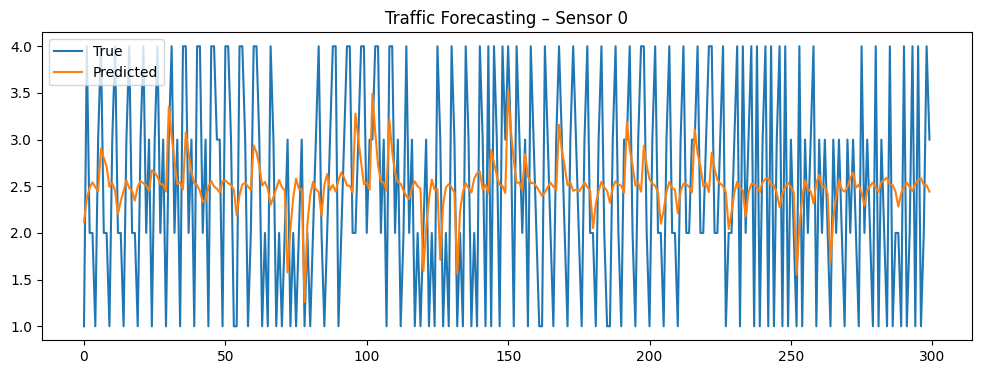

In [49]:
sensor = 0  # first sensor

true_seq = y_trues_inv[:, :, sensor].reshape(-1)[:300]
pred_seq = y_preds_inv[:, :, sensor].reshape(-1)[:300]

plt.figure(figsize=(12,4))
plt.plot(true_seq, label="True")
plt.plot(pred_seq, label="Predicted")
plt.legend()
plt.title("Traffic Forecasting – Sensor 0")
plt.show()
